#FINAL EXPORT (BEST MODEL)

In [1]:
from pathlib import Path
import subprocess

ROOT = Path(subprocess.check_output(["git", "rev-parse", "--show-toplevel"]).decode().strip())


In [2]:

# # FINAL EXPORT (BEST MODEL) — NN baseline without rolling7 (Kaggle ~0.19488)

# %%
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_percentage_error

import tensorflow as tf
from tensorflow import keras

# 1) Load data


train_path = ROOT / "data" / "processed" / "df_train_data_cleaned.csv"
val_path   = ROOT / "data" / "processed" / "df_validation_data_cleaned.csv"
test_path  = ROOT / "data" / "processed" / "df_test_data_cleaned.csv"



df_train = pd.read_csv(train_path)
df_val   = pd.read_csv(val_path)
df_test  = pd.read_csv(test_path)

for df in (df_train, df_val, df_test):
    df["Datum"] = pd.to_datetime(df["Datum"], errors="coerce")

target = "Umsatz_umsatz"

# 2) Split X/y
X_train = df_train.drop(columns=[target, "Datum"])
y_train = df_train[target].astype(float)

X_val = df_val.drop(columns=[target, "Datum"])
y_val = df_val[target].astype(float)

# test has no target
X_test = df_test.drop(columns=["Datum"])

# 3) Drop rolling7 (best model)
drop_cols = ["umsatz_rolling7"]
X_train = X_train.drop(columns=drop_cols, errors="ignore")
X_val   = X_val.drop(columns=drop_cols, errors="ignore")
X_test  = X_test.drop(columns=drop_cols, errors="ignore")

# 4) Ensure categorical as string
cat_cols = ["Warengruppe_umsatz"]
for df in (X_train, X_val, X_test):
    df["Warengruppe_umsatz"] = df["Warengruppe_umsatz"].astype(int).astype(str)

# 5) Align columns (very important)
# make sure val/test have exactly same feature columns as train
X_val  = X_val.reindex(columns=X_train.columns, fill_value=0)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# 6) Preprocess (scaling + one-hot)
num_cols = [c for c in X_train.columns if c not in cat_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop",
)

X_train_p = preprocess.fit_transform(X_train)
X_val_p   = preprocess.transform(X_val)
X_test_p  = preprocess.transform(X_test)

print("Shapes:", X_train_p.shape, X_val_p.shape, X_test_p.shape)

# 7) Build + train NN (same architecture)
tf.random.set_seed(42)

model = keras.Sequential([
    keras.layers.Input(shape=(X_train_p.shape[1],)),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(1),
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mape",                 # to match Kaggle metric
    metrics=["mae"]
)

early = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train_p, y_train,
    validation_data=(X_val_p, y_val),
    epochs=200,
    batch_size=32,
    callbacks=[early],
    verbose=1
)

# quick sanity check on val (MAPE)
pred_val = model.predict(X_val_p).ravel()
pred_val = np.clip(pred_val, 0, None)
val_mape = mean_absolute_percentage_error(y_val, pred_val) * 100
print(f"Validation MAPE %: {val_mape:.2f}")

# 8) Predict test + create submission
pred_test = model.predict(X_test_p).ravel()
pred_test = np.clip(pred_test, 0, None)

submission = df_test[["id"]].copy()
submission["umsatz"] = pred_test

out_path   = ROOT / "data" / "processed" / "submission_nn_best.csv"
submission.to_csv(out_path, index=False)

print("Saved:", out_path)
print("rows:", len(submission))
print("pred mean/min/max:",
      float(submission["umsatz"].mean()),
      float(submission["umsatz"].min()),
      float(submission["umsatz"].max()))
print(submission.head())


2026-01-02 15:37:19.116911: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-02 15:37:19.117283: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-02 15:37:19.179130: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-02 15:37:21.468766: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

Shapes: (7487, 18) (1841, 18) (1830, 18)
Epoch 1/200


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):
2026-01-02 15:37:22.222939: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 75.0804 - mae: 171.3620 - val_loss: 45.7339 - val_mae: 105.3755
Epoch 2/200
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 41.7062 - mae: 104.8895 - val_loss: 33.1959 - val_mae: 76.6839
Epoch 3/200
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 30.2648 - mae: 72.1220 - val_loss: 25.1329 - val_mae: 52.2206
Epoch 4/200
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24.8413 - mae: 55.4181 - val_loss: 23.9668 - val_mae: 47.9451
Epoch 5/200
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 23.3324 - mae: 51.1935 - val_loss: 23.0244 - val_mae: 45.8325
Epoch 6/200
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 22.4175 - mae: 49.1140 - val_loss: 22.3465 - val_mae: 44.2539
Epoch 7/200
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.6972 - mae: 47.4056 - val_loss: 21.7921 - val_mae: 43.0906
Epoch 8/200
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.1588 - mae: 46.0434 - val_loss: 21.2216 - val_mae: 41.5100
Epoch 9/200
234/234 ━━━━━

In [3]:
print("y_train min/max:", y_train.min(), y_train.max())
print("pred_val min/max:", pred_val.min(), pred_val.max())

y_train min/max: 12.9373828412174 1879.46183076734
pred_val min/max: 27.807058 657.8484


In [4]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# predictions already computed: pred_val
rmse = np.sqrt(mean_squared_error(y_val, pred_val))
r2   = r2_score(y_val, pred_val)
mae  = mean_absolute_error(y_val, pred_val)

print(f"Validation MAPE %: {val_mape:.2f}")
print(f"Validation RMSE : {rmse:.2f}")
print(f"Validation R2   : {r2:.4f}")
print(f"Validation MAE  : {mae:.2f}")

Validation MAPE %: 19.04
Validation RMSE : 52.87
Validation R2   : 0.8348
Validation MAE  : 32.83


#Plot 1: Loss curves (Train vs Val)

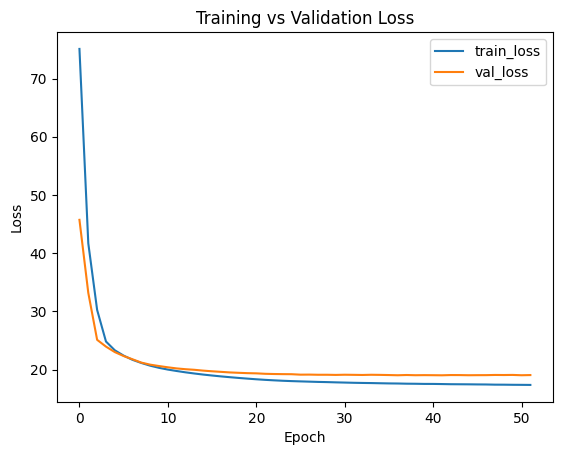

In [5]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()


#Plot 2: Actual vs Pred (Validation)

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


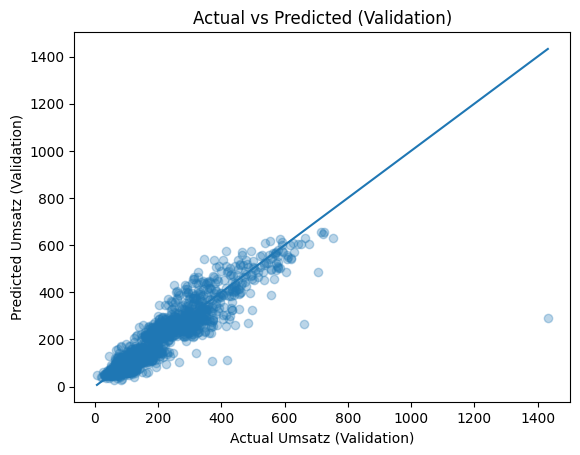

In [6]:
import numpy as np
import matplotlib.pyplot as plt

pred_val = model.predict(X_val_p).ravel()
pred_val = np.clip(pred_val, 0, None)

plt.figure()
plt.scatter(y_val, pred_val, alpha=0.3)
plt.xlabel("Actual Umsatz (Validation)")
plt.ylabel("Predicted Umsatz (Validation)")
plt.title("Actual vs Predicted (Validation)")

mn = min(y_val.min(), pred_val.min())
mx = max(y_val.max(), pred_val.max())
plt.plot([mn, mx], [mn, mx])
plt.show()
